In [3]:
# Imports
import numpy as np
import optuna
from hftbacktest import BacktestAsset, HashMapMarketDepthBacktest
from hftbacktest import Recorder
from hftbacktest.stats import LinearAssetRecord

from src.strategies import glft

# Data Input paths
preprocessed_data_path = "../data/daily_processed"
daily_eod_snapshots = "../data/snapshots" # EOD = End Of Day 

In [4]:
day_start = 2
day_end = 32
data = []
latencies = []

for i in range(day_start, day_end):
    day = str(i) if i > 9 else "0" + str(i)
    day_file = f"../data/daily_processed/deribit_eth_perp_2025-01-{day}.npz"
    day_latency = f"../data/latencies/latency_2025-01-{day}_latency.npz"
    data.append(day_file)
    # latencies.append(day_latency)
day_start_str = str(day_start - 1) if day_start > 10 else "0" + str(day_start - 1)
eod = np.load(f"../data/snapshots/deribit_eth_perp_2025-01-{day_start_str}_eod.npz")['data']

In [5]:
# Contract-specific constants (change to match the instrument)
TICK_SIZE = 0.05          # min price increment
LOT_SIZE  = 10            # contracts per lot
NOTIONAL  = 1.0           # linear P&L multiplier (1 for USD-quoted futures)

# Taken from https://support.deribit.com/hc/en-us/articles/25944746248989-Fees
MAKER_FEE = -0.0001   
TAKER_FEE =  0.0005      

# # Model parameters (feel free to calibrate them – see comments below)
# GAMMA       = 0.1     # risk aversion
# K_INTENSITY = 1.5     # λ(δ)=A·e^{-kδ}  →  k
# A_INTENSITY = 2.0     # λ(δ)=A·e^{-kδ}  →  A
# T_HORIZON   = 8*60*60 # sec until “end of day”
# DT_NS       = 100_000_000             
# VOL_WINDOW  = 600                     # 60 s rolling window in steps

In [ ]:
asset = (
    BacktestAsset()
        .data(data)
        .initial_snapshot(eod)
        .linear_asset(1.0)
        # .intp_order_latency(latencies, True)
        # .constant_latency(100_000_000, 100_000_000) # Constant latency model (nanoseconds) values inspired from https://roq-trading.com/docs/blogs/2023-01-12/deribit/
        # .risk_adverse_queue_model()
        .power_prob_queue_model(2.0)
        .no_partial_fill_exchange()
        .trading_value_fee_model(MAKER_FEE, TAKER_FEE)
        .tick_size(0.01) # Tick size of this asset: minimum price increasement
        .lot_size(1) # Lot size of this asset: minimum trading unit
        # .roi_lb(0.0) # Sets the lower bound price for the range of interest in the market depth.
        # .roi_ub(3000.0) # Sets the upper bound price for the range of interest in the market depth.
        .last_trades_capacity(10000)
)

hbt = HashMapMarketDepthBacktest([asset])

n_trading_days = day_end - day_start
recorder = Recorder(1, n_trading_days* 1_000_000)

out = glft.gridtrading_glft_mm(hbt, recorder.recorder, n_trading_days)

hbt.close()

Hour: 0
Trading day:  0
Hour: 1
Hour: 2
Hour: 3
Hour: 4
Hour: 5
Hour: 6
Hour: 7
Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13
Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20
Hour: 21
Hour: 22
Hour: 23
Hour: 0
Trading day:  1


start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTradingValue,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-01-20 00:00:00,2025-01-20 23:59:50,-7.269115,-9.24491,-303.325,658.395,1029.119111,3.4203e6,-0.460704,-0.000089,76717.075


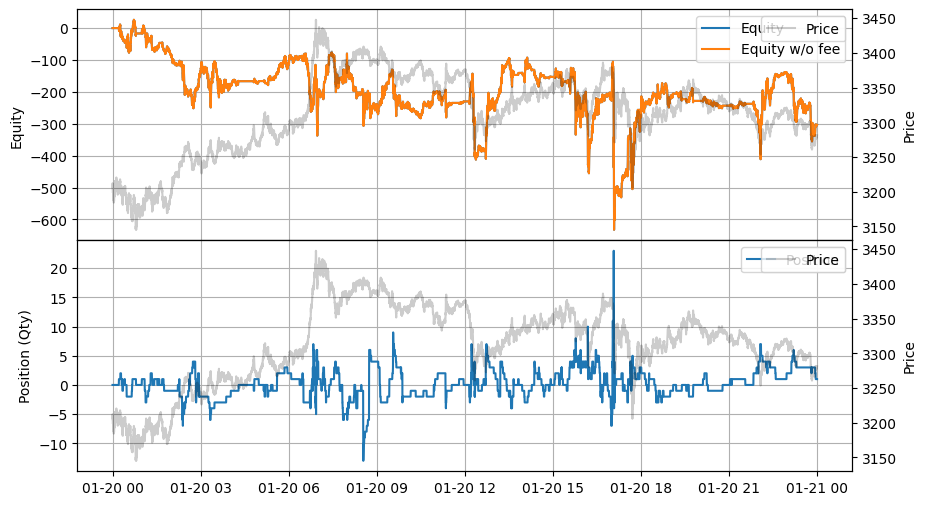

In [35]:
stats = LinearAssetRecord(recorder.get(0)).stats()
stats.plot()
stats.summary(pretty=True)